COVID GDP
==========

This notebook explores the relationship betwen COVID-19 cases and GDP 

# Define general variables

In [156]:
""" Load modules """
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import math
import geopandas as gpd
import pyproj

# Input data

## Covid incidence and GDP data from Our World in Data

In [2]:
""" Data file """
covid_gdp_data_file = 'owd-data-total-covid_19_incidence_gdp_per_capita-20210130.csv'
covid_gdp_data_path = '../data/' + covid_gdp_data_file

In [3]:
""" Load GDP and covid data """
gdp_covid_data = pd.read_csv(covid_gdp_data_path, low_memory=False)

In [4]:
""" Rename data variables """
gdp_covid_data.columns = ['country', 'code', 'year', 'continent', 'gdp', 'date', 'incidence', 'notes']

In [5]:
""" Remove entries with no country code (continents and special locations)"""
gdp_covid_data.dropna(subset=['code'], inplace=True)

# Remove countries with missing values on incidence or gdp
gdp_covid_data = pd.concat([gdp_covid_data.dropna(subset=['incidence']),
                            gdp_covid_data.dropna(subset=['gdp'])])

gdp_covid_data.head()

,country,code,year,continent,gdp,date,incidence,notes
17,Afghanistan,AFG,NaN,NaN,NaN,2020-02-24,0.026,NaN
18,Afghanistan,AFG,NaN,NaN,NaN,2020-02-25,0.026,NaN
19,Afghanistan,AFG,NaN,NaN,NaN,2020-02-26,0.026,NaN
20,Afghanistan,AFG,NaN,NaN,NaN,2020-02-27,0.026,NaN
21,Afghanistan,AFG,NaN,NaN,NaN,2020-02-28,0.026,NaN


## Countries names

In [6]:
""" Extract country names """
countries_names = gdp_covid_data.loc[:, ['country', 'code']].drop_duplicates().set_index('code')
countries_names

,country
code,
AFG,Afghanistan
ALB,Albania
DZA,Algeria
AND,Andorra
AGO,Angola
...,...
PRI,Puerto Rico
SXM,Sint Maarten (Dutch part)
TON,Tonga


## Continent names

In [7]:
continents = gdp_covid_data.loc[:, 'continent'].dropna().unique()

## GDP per capita

In [8]:
""" Extract DGP per capital data """
gdp_data = gdp_covid_data.loc[gdp_covid_data.loc[:, 'gdp'].notnull(), ['code', 'year', 'gdp']].copy()
gdp_data.head()

,code,year,gdp
1,AFG,2002.0,1063.635574
2,AFG,2003.0,1099.194507
3,AFG,2004.0,1062.249360
4,AFG,2005.0,1136.123214
5,AFG,2006.0,1161.124889


In [9]:
""" Reshape GDP data by annual value """
gdp_annual = gdp_data.pivot(index='code', columns='year', values='gdp')
gdp_annual.head()

year,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
code,,,,,,,,,,,,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,35973.780510,NaN,NaN,NaN,NaN,NaN,NaN
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1298.143159,1531.173993,1614.255001,1660.739856,1839.273579,1848.700026,1838.960244,1809.016488,1802.695565,1803.987487
AGO,3430.798427,3359.374794,3062.042696,2252.051608,2210.066786,2465.396619,2720.521329,2839.758717,2893.334472,2873.883924,...,5978.323249,5908.042248,5897.682841,5911.254092,5999.902106,6188.003756,6257.152874,6227.664689,5972.451513,5819.494971
ALB,4722.838166,3345.504049,3123.512503,3444.321792,3753.169904,4278.689663,4697.153233,4214.358153,4623.026401,5280.527867,...,9153.788206,9524.649303,9927.181841,10207.764699,10369.823382,10492.806283,10701.120786,10970.452245,11356.341329,11803.430594
ARE,110432.464979,105171.409619,102615.170342,98224.516475,99529.780723,100976.945075,101754.295698,104829.027296,100018.103764,97753.828420,...,71314.668819,60769.861028,57232.618076,58363.678216,59419.089491,61688.380299,63943.185829,66569.403414,67705.949329,67293.482759


In [10]:
""" List countries with missing data per year """
gdp_annual.isna().sum(axis=0)

year
1990.0    32
1991.0    31
1992.0    29
1993.0    28
1994.0    26
1995.0    17
1996.0    15
1997.0    13
1998.0    13
1999.0    12
2000.0     8
2001.0     7
2002.0     6
2003.0     6
2004.0     6
2005.0     6
2006.0     6
2007.0     5
2008.0     5
2009.0     5
2010.0     5
2011.0     0
2012.0     5
2013.0     5
2014.0     6
2015.0     7
2016.0     7
2017.0    10
dtype: int64

In [11]:
""" Extract covid incidence data """
covid_data = gdp_covid_data.loc[gdp_covid_data.loc[:, 'incidence'].notnull(), ['code', 'date', 'incidence']].copy()
covid_data.head()

,code,date,incidence
17,AFG,2020-02-24,0.026
18,AFG,2020-02-25,0.026
19,AFG,2020-02-26,0.026
20,AFG,2020-02-27,0.026
21,AFG,2020-02-28,0.026


In [12]:
covid_daily = covid_data.pivot(index='code', columns='date', values='incidence')
covid_daily.head()

date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-01-20,2021-01-21,2021-01-22,2021-01-23,2021-01-24,2021-01-25,2021-01-26,2021-01-27,2021-01-28,2021-01-29
code,,,,,,,,,,,,,,,,,,,,,
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1394.306,1397.517,1399.572,1401.524,1402.449,1404.427,1406.430,1409.102,1410.052,1411.285
AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,580.930,583.486,586.285,589.267,590.240,592.583,594.926,595.748,598.547,600.099
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24059.351,24294.948,24551.741,24824.866,25114.323,25301.272,25606.713,25911.113,26219.334,26530.683
AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120468.517,121387.433,121866.304,122940.529,123587.653,124195.949,124739.533,125749.045,126564.421,127315.084
ARE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404,0.404,0.404,...,26665.150,27021.961,27381.097,27741.648,28103.515,28466.594,28830.684,29228.949,29629.944,30030.535


From this data, it seems that all countries have been touched by covid since January 21, 2021. To be further investigated with plot

On January 20, 2021, the Federal States of Micronesia was the last state to publically declare existing cases of COVID-19 on its territory.

In [13]:
""" Select day of refence for COVID count """
date = '2021-01-28'
covid_variable = covid_daily.loc[:, date]
covid_variable = np.log(covid_variable)
covid_variable.name = 'covid'

In [14]:
""" Select year of reference for GDP """
gpd_year = 2011
gdp_variable = gdp_annual.loc[:, gpd_year]
gdp_variable = np.log(gdp_variable)
gdp_variable.name = 'gdp'

In [15]:
model_data = pd.concat([gdp_variable, covid_variable], axis=1).copy()
##model_data = model_data.dropna(axis=0).copy()
model_data.head()

,gdp,covid
code,,
ABW,10.490546,NaN
AFG,7.415018,7.251382
AGO,8.684613,6.394505
ALB,9.230904,10.174252
ARE,10.974449,10.296541


## Country sets

In [16]:
""" Countries indexes sets """
countries_indexes = {}

# World countries indexes
countries_indexes['World'] = list(gdp_covid_data.dropna(subset=['gdp']).loc[:, 'code'].unique())

# Continents countries indexes
countries_indexes = {**countries_indexes, **gdp_covid_data.groupby('continent')['code'].apply(list).to_dict()}

## Plot scatter of GDP / COVID and polynomial regression model

In [160]:
def plot_model(data, scatter, label, color, linewidth, alpha, model_legend, model_name, ax):
    """ 
    Plot regression model and data scatter
    """
    
    # Compute model
    x = np.array(data.loc[:, 'gdp'])
    y = np.array(data.loc[:, 'covid'])
    mymodel = np.poly1d(np.polyfit(x, y, 1))
    vmin, vmax = x.min()-.2, x.max()+.2
    
    # Define model line
    myline = np.linspace(vmin, vmax, 100)
    
    # Plot scatter
    if scatter == True:
        if color == False:
            ax.scatter(x, y)
        else:
            ax.scatter(x, y, c=color, alpha=alpha+.2)
    else:
        pass
    
    # Plot scatter labels
    if label == True:
        for i, txt in enumerate(data.index):
            ax.annotate(txt, (x[i], y[i]), alpha=0.5)
            
    # Relabel scale with non-log values
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    plt.yticks(np.log([10, 100, 1000, 10000, 100000]),
               ['10', '100', '1,000', '10,000', '100,000'])
    plt.xticks(np.log([1000, 2000, 5000, 10000, 20000, 50000, 100000]),
           ['1,000', '2,000', '5,000', '10,000', '20,000', '50,000', '100,000'])
    
    # Plot
    if color==False:
        plt.plot(myline,
                 mymodel(myline),
                 linewidth=linewidth,
                 alpha=alpha,
                 linestyle='dashed',
                 label=model_name)   
    else:
        plt.plot(myline,
                 mymodel(myline),
                 c=color,
                 linewidth=linewidth,
                 alpha=alpha,
                 linestyle='dashed',
                 label=model_name)
        
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
        
    if model_legend==True:
        ax.legend()

In [158]:
""" Set color codes """
colors = {'World':'purple',
          'Asia':'dodgerblue',
          'Africa':'red',
          'Europe':'green',
          'North America':'orange',
          'South America':'brown',
          'Oceania':'darkkhaki'}

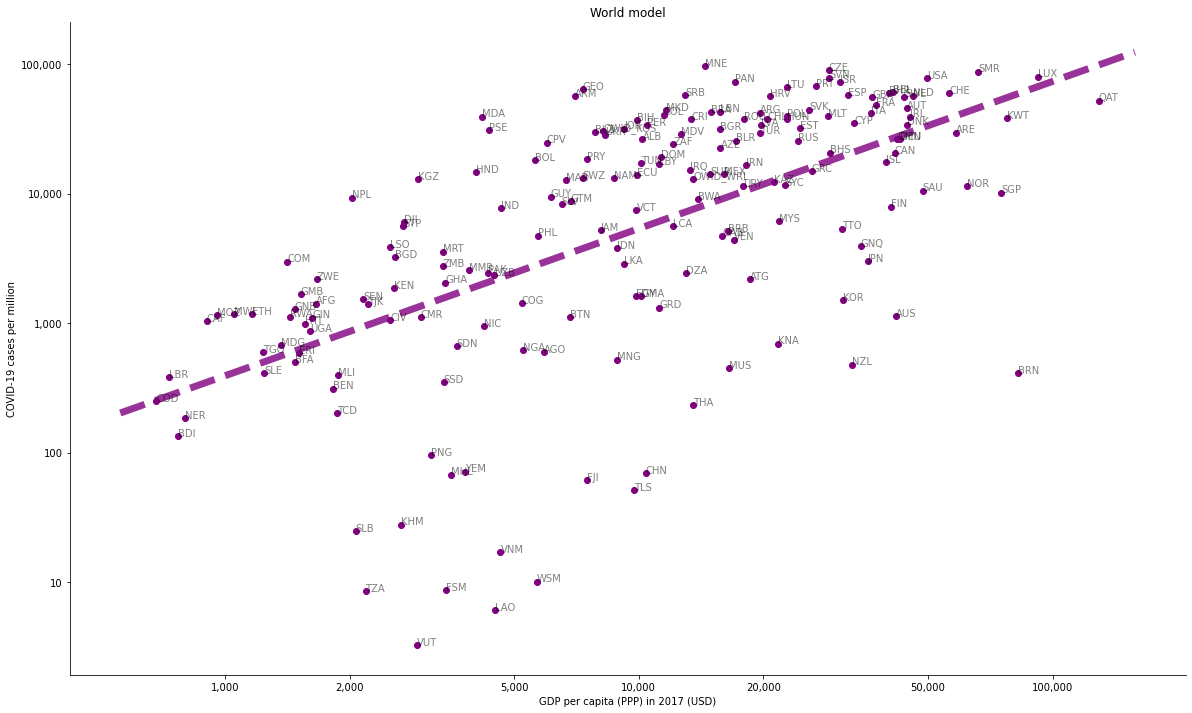

In [168]:
plot_data = model_data.loc[countries_indexes['World']].dropna()

fig, ax = plt.subplots(figsize=(20, 12))

# Plost model on world set
plot_model(plot_data,
           scatter=True,
           label=True,
           color=colors['World'],
           linewidth=7,
           alpha=0.8,
           model_legend=False,
           model_name='World',
           ax=ax)

ax.set(title='World model',
       xlabel='GDP per capita (PPP) in 2017 (USD)',
       ylabel='COVID-19 cases per million')

plt.show()

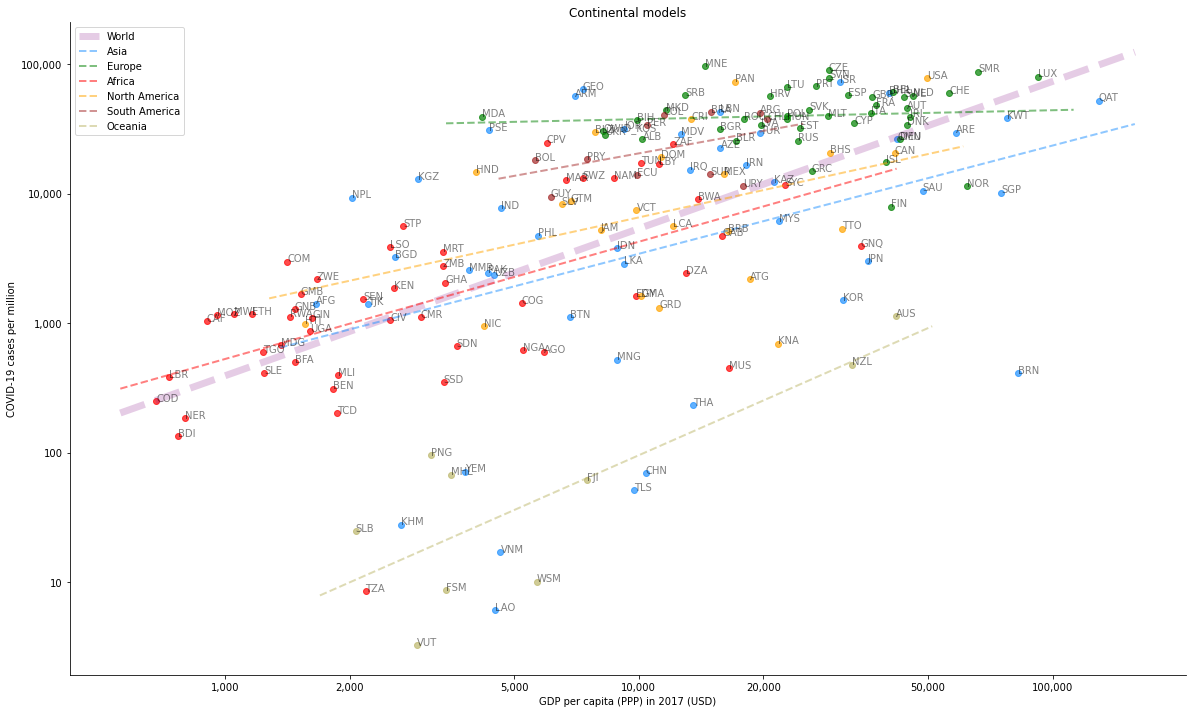

In [178]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plot model on world set
plot_data = model_data.loc[countries_indexes['World']].dropna()
plot_model(plot_data,
           scatter=False,
           label=False,
           color=colors['World'],
           linewidth=7,
           alpha=0.2,
           model_legend=False,
           model_name='World',
           ax=ax)

# Plot model on continental sets
for continent in continents:
    plot_data = model_data.loc[countries_indexes[continent]].dropna()
    plot_model(plot_data,
               scatter=True,
               label=True,
               color=colors[continent],
               linewidth=2,
               alpha=0.5,
               model_legend=True,
               model_name=continent,
               ax=ax)
    
ax.set(title='Continental models',
       xlabel='GDP per capita (PPP) in 2017 (USD)',
       ylabel='COVID-19 cases per million')


plt.show()

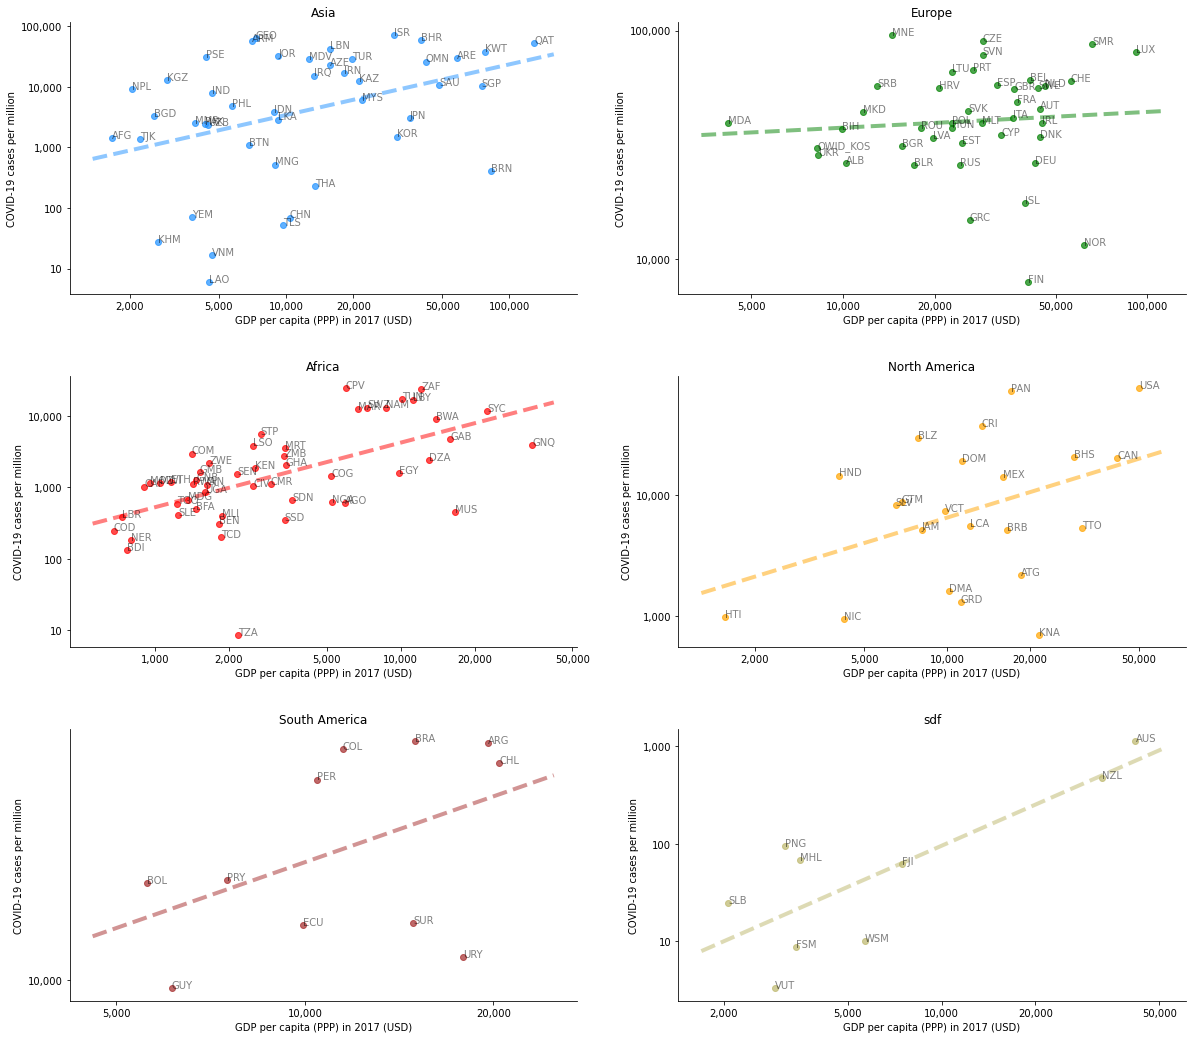

In [166]:
""" Plot continental models """
# Define ax locations
ax_locs = [[0,0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1]]

fig, axs = plt.subplots(3, 2, figsize=(20, 18))

for i, continent in enumerate(continents):
    ax = plt.subplot(axs[ax_locs[i][0],
                         ax_locs[i][1]])
    plot_data = model_data.loc[countries_indexes[continent]].dropna()
    plot_model(plot_data,
               scatter=True,
               label=True,
               color=colors[continent],
               linewidth=4,
               alpha=0.5,
               model_legend=False,
               model_name=continent,
               ax=ax)
    ax.set(title=continent, xlabel='GDP per capita (PPP) in 2017 (USD)', ylabel='COVID-19 cases per million')
    
plt.subplots_adjust(hspace=0.3)

plt.show()

## Plot linear model for Asia sub-continental regions
To present after statistical value tables of continental regions

In [170]:
""" Output list of asian countries and sub-continent """
asian_countries_data_path = '../data/koseki-data-countries_asia-20211231.csv'
#asian_countries = countries_names.loc[continent_names.loc[continent_names.loc[:, 'continent']=='Asia'].index]
#asian_countries.to_csv(asian_countries_data_path)
asian_countries_data = pd.read_csv(asian_countries_data_path, index_col=0)

In [182]:
""" List Asian subcontinents """
asia_subcontinents = ['western', 'central', 'eastern']

In [172]:
""" Add Asia subcontinental country sets to selection indexes """
countries_indexes = {**countries_indexes,
                     **asian_countries_data.reset_index().groupby('subcontinent')['code'].apply(list).to_dict()}

In [173]:
""" Ass Asia subcontinental colors """
colors = {**colors,
          **{'central':'deepskyblue',
             'western':'steelblue',
             'eastern':'lightblue'}}

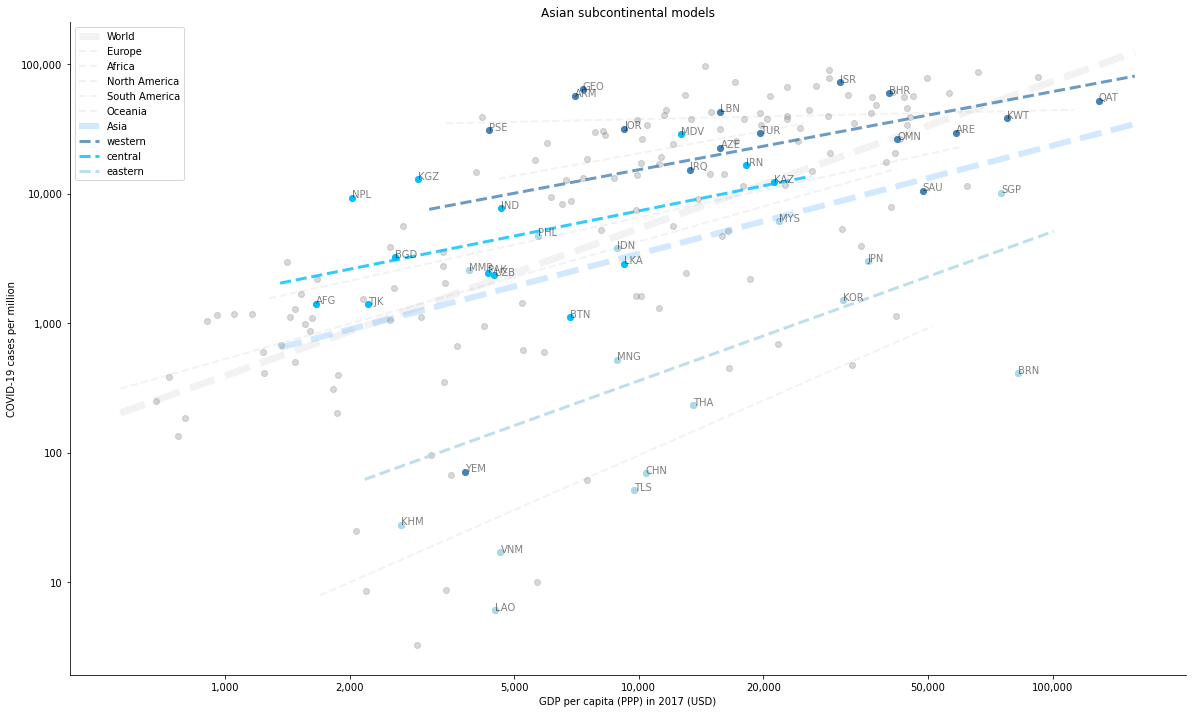

In [183]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plot world model line
plot_data = model_data.loc[countries_indexes['World']].dropna()
plot_model(plot_data,
           scatter=False,
           label=False,
           color='grey',
           linewidth=7,
           alpha=0.1,
           model_legend=False,
           model_name='World',
           ax=ax)

# Plot continents scatter and model line
for continent in continents:
    if continent != 'Asia':
        plot_data = model_data.loc[countries_indexes[continent]].dropna()
        plot_model(plot_data,
                   scatter=True,
                   label=False,
                   color='grey',
                   linewidth=2,
                   alpha=0.1,
                   model_legend=False,
                   model_name=continent,
                   ax=ax)

# Plot asian model line
plot_data = model_data.loc[countries_indexes['Asia']].dropna()
plot_model(plot_data,
           scatter=True,
           label=False, 
           color=colors['Asia'],
           linewidth=6,
           alpha=0.2,
           model_legend=True,
           model_name='Asia',
           ax=ax)
        
# Plot Asian subcontinent scatter and model line    
for subcontinent in asia_subcontinents:
    plot_data = model_data.loc[countries_indexes[subcontinent]].dropna()
    plot_model(plot_data,
               scatter=True,
               label=True,
               color=colors[subcontinent],
               linewidth=3,
               alpha=0.8,
               model_legend=True,
               model_name=subcontinent,
               ax=ax)
    
ax.set(title='Asian subcontinental models', xlabel='GDP per capita (PPP) in 2017 (USD)', ylabel='COVID-19 cases per million')
    
plt.show()

## Model attributes

In [184]:
def linear_regression_model(x, y):
    model = LinearRegression()
    model.fit(x, y)
    model = LinearRegression().fit(x, y)
    return model

In [185]:
def model_parameters(data):
    x = np.array(data.loc[:, 'gdp']).reshape((-1, 1))
    y = np.array(data.loc[:, 'covid'])

    model = linear_regression_model(x, y)
    r = model.score(x, y)
    c = model.coef_[0]
    i = model.intercept_
    
    return ['%.4f' % x for x in [r, c, i]]

In [186]:
""" Output model attributes for World model """
d = {'World':model_parameters(model_data.loc[countries_indexes['World']].dropna())}
world_model = pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

# Save table
world_model.to_csv('../figures/koseki-table-covid_gdp_world_model.csv')

# Show table
world_model

,r2,slope,intercept
World,0.3597,1.1370,-1.8836


In [187]:
""" Output model attributes for Continental models """
d = {}
for continent in continents:
    df = model_data.loc[countries_indexes[continent]].dropna()
    d[continent]=model_parameters(df)

continental_models = pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

# Save table
continental_models.to_csv('../figures/koseki-table-covid_gdp_continental_models.csv')

# Show table
continental_models

,r2,slope,intercept
Asia,0.1492,0.8361,0.4390
Europe,0.0068,0.0691,9.8982
Africa,0.3515,0.9058,0.0112
North America,0.1654,0.7001,2.3386
South America,0.2093,0.5772,4.6093
Oceania,0.6394,1.4053,-8.3854


In [188]:
""" Compute model attributes for Africa, excluding Tanzania """
d = {'Africa*':model_parameters(model_data.loc[countries_indexes['Africa']].dropna().drop('TZA'))}
pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

,r2,slope,intercept
Africa*,0.4221,0.8724,0.3770


In [189]:
model_data.loc[countries_indexes['South America']]

,gdp,covid
code,,
ARG,9.884781,10.649264
BOL,8.630255,9.801033
BRA,9.614010,10.660013
CHL,9.925137,10.528302
COL,9.349796,10.612360
ECU,9.203004,9.542744
GUY,8.721087,9.158738
PRY,8.923279,9.817653
PER,9.254270,10.427787


In [190]:
""" Sub-continental regressions (Asia) """
d = {}
for subcontinent in asia_subcontinents:
    df = model_data.loc[countries_indexes[subcontinent]].dropna()
    d[subcontinent]=model_parameters(df)
    
asian_models = pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

# Save table
asian_models.to_csv('../figures/koseki-table-covid_gdp_asian_models.csv')

# Show table
asian_models

,r2,slope,intercept
western,0.1509,0.6035,4.0770
central,0.2566,0.6440,2.9712
eastern,0.2594,1.1509,-4.7174


In [191]:
""" Compute model attributes for Western Asia excluding Yemen """
df = model_data.loc[countries_indexes['western']].dropna().drop('YEM')
d = {'Western Asia*':model_parameters(df)}
pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

,r2,slope,intercept
Western Asia*,0.0019,-0.0238,10.6826


In [ ]:
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [118]:
filtered_regression_data = model_data.loc[~model_data.index.isin(eastern_asia_idx+oceania_idx)]

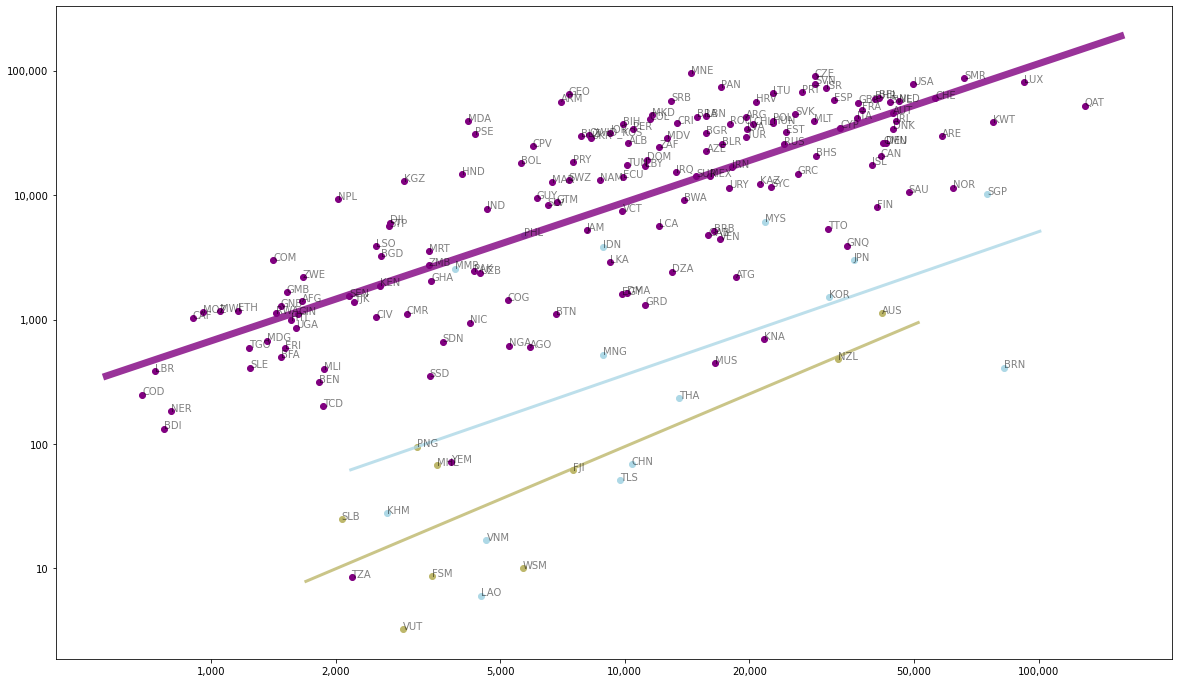

In [119]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plot model of world minus oceania and eastern asia countries
plot_model(filtered_regression_data,
           scatter=True,
           label=True,
           color=colors['World'],
           linewidth=7,
           alpha=0.8,
           ax=ax)

# Plot model of oceania countries
plot_model(model_data.loc[oceania_idx],
           scatter=True,
           label=True,
           color=colors['Oceania'],
           linewidth=3,
           alpha=0.8,
           ax=ax)

# Plot model of oceania countries
plot_model(model_data.loc[eastern_asia_idx],
           scatter=True,
           label=True,
           color=asiacolors['eastern'],
           linewidth=3,
           alpha=0.8,
           ax=ax)

plt.show()

In [120]:
""" Output model attributes for World model """
d = {'West of Himalayas':model_parameters(filtered_regression_data)}
world_model_filtered = pd.DataFrame.from_dict(d, orient='index', columns=['r2', 'slope', 'intercept'])

# Save table
world_model_filtered.to_csv('../figures/koseki-table-covid_gdp_world_model_filtered.csv')

# Show table
world_model_filtered

,r2,slope,intercept
West of Himalayas,0.5575,1.1137,-1.1815


## Models error values

In [136]:
""" World errors """
x = model_data.loc[:, 'gdp'].values.reshape((-1, 1))
y = model_data.loc[:, 'covid'].values

model = linear_regression_model(x, y)

model_y = model.predict(x)
true_y = model_data.loc[:,'covid']

world_error = true_y - model_y

world_error

code
AFG    0.705902
AGO   -1.593452
ALB    1.565615
ARE   -0.293063
ARG    1.297710
         ...   
WSM   -5.629558
YEM   -3.223705
ZAF    1.292258
ZMB    0.568169
ZWE    1.144759
Name: covid, Length: 182, dtype: float64

In [124]:
""" Filtered World """
x = filtered_regression_data.loc[:, 'gdp'].values.reshape((-1, 1))
y = filtered_regression_data.loc[:, 'covid'].values

model = linear_regression_model(x, y)

model_y = model.predict(x)
true_y = filtered_regression_data.loc[:,'covid']

filtered_world_error = true_y - model_y

filtered_world_error

code
AFG    0.174638
AGO   -2.096215
ALB    1.075117
ARE   -0.744420
ARG    0.821890
         ...   
VEN   -1.274660
YEM   -3.736356
ZAF    0.805612
ZMB    0.052732
ZWE    0.613581
Name: covid, Length: 158, dtype: float64

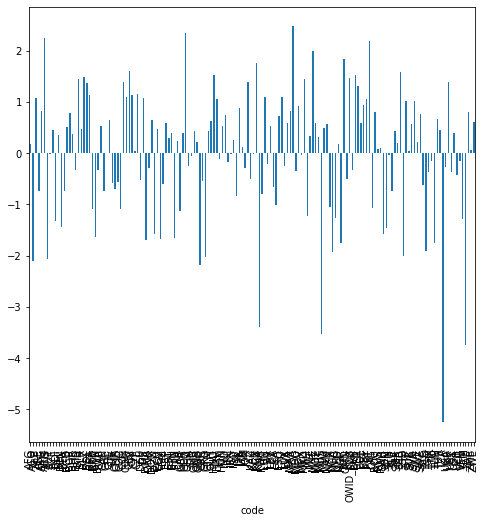

In [125]:
fig, ax = plt.subplots(figsize=(8, 8))

filtered_world_error.plot.bar(ax=ax)

plt.show()

In [127]:
oceania_regression_data = model_data.loc[oceania_idx].copy()

In [128]:
""" Oceania """
x = oceania_regression_data.loc[:, 'gdp'].values.reshape((-1, 1))
y = oceania_regression_data.loc[:, 'covid'].values

model = linear_regression_model(x, y)

model_y = model.predict(x)
true_y = oceania_regression_data.loc[:,'covid']

oceania_error = true_y - model_y

oceania_error

code
AUS    0.458870
FJI   -0.034423
FSM   -0.884136
MHL    1.125717
NZL   -0.054256
PNG    1.618556
SLB    0.863420
VUT   -1.644814
WSM   -1.448934
Name: covid, dtype: float64

In [129]:
""" Eastern Asia """
eastern_regression_data = model_data.loc[eastern_asia_idx].copy()

x = eastern_regression_data.loc[:, 'gdp'].values.reshape((-1, 1))
y = eastern_regression_data.loc[:, 'covid'].values

model = linear_regression_model(x, y)

model_y = model.predict(x)
true_y = eastern_regression_data.loc[:,'covid']

eastern_error = true_y - model_y

eastern_error

code
BRN   -2.290849
CHN   -1.687738
IDN    2.500810
JPN    0.659774
KHM   -1.036962
KOR    0.126215
LAO   -3.162819
MMR    3.048154
MNG    0.510652
MYS    1.939254
PHL    3.226801
SGP    1.022494
THA   -0.782741
TLS   -1.906711
VNM   -2.166335
Name: covid, dtype: float64

## Map regressions square errors

In [130]:
""" Input countries GIS dataset """
file = '../data/TM_WORLD_BORDERS_SIMPL-0.3.shp'
countries_wgs84 = gpd.read_file(file)
# Remove Antartica (to avoid problems with alternative projections)
countries_wgs84 = countries_wgs84.loc[countries_wgs84.NAME != 'Antarctica']

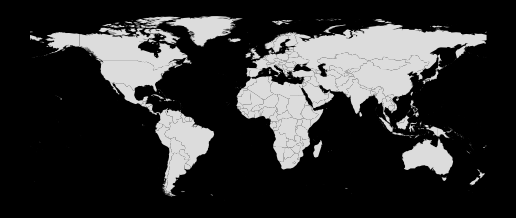

In [131]:
""" Plot WGS84 projected GIS datasets """
fig, ax = plt.subplots(figsize=(9,9))

# Plot the country borders
countries_wgs84.plot(ax=ax, color='gainsboro')

fig.set_facecolor('black')
ax.axis('off')
plt.show()

<AxesSubplot:>

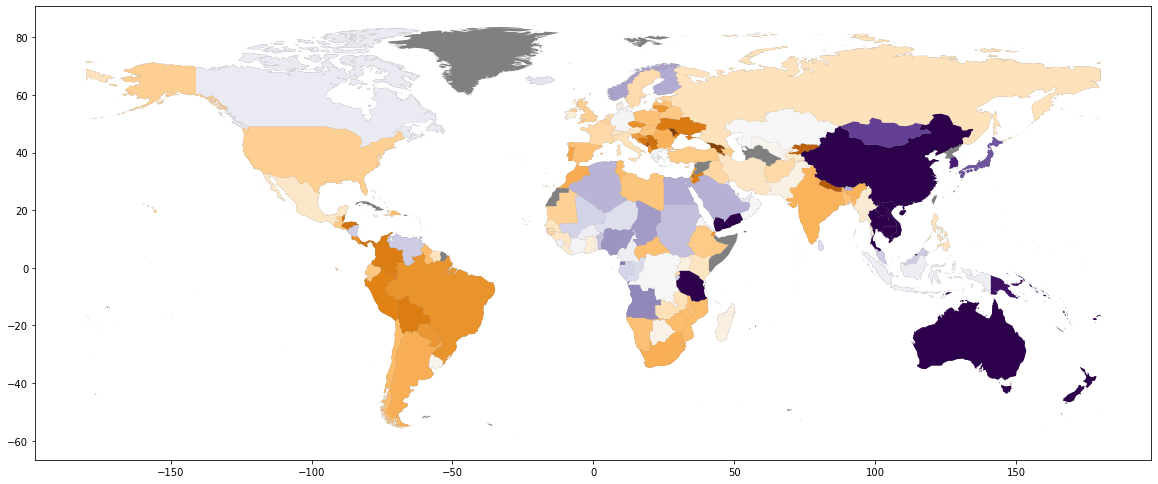

In [137]:
fig, ax = plt.subplots(figsize=(20,20))

countries_wgs84.plot(color='grey', ax=ax)

pd.concat([countries_wgs84.set_index('ISO3'),
           world_error], axis=1).plot(column='covid',
                                               cmap='PuOr_r',
                                               vmax=3,
                                               vmin=-3,
                                               ax=ax)

<AxesSubplot:>

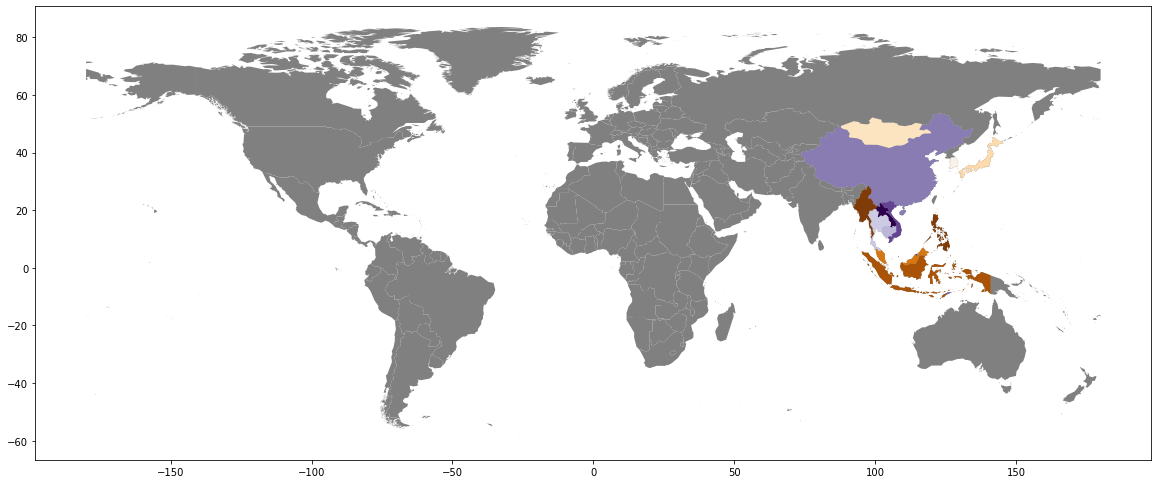

In [138]:
fig, ax = plt.subplots(figsize=(20,20))

countries_wgs84.plot(color='grey', ax=ax)

pd.concat([countries_wgs84.set_index('ISO3'),
           eastern_error], axis=1).plot(column='covid',
                                               cmap='PuOr_r',
                                               vmax=3,
                                               vmin=-3,
                                               ax=ax)


<AxesSubplot:>

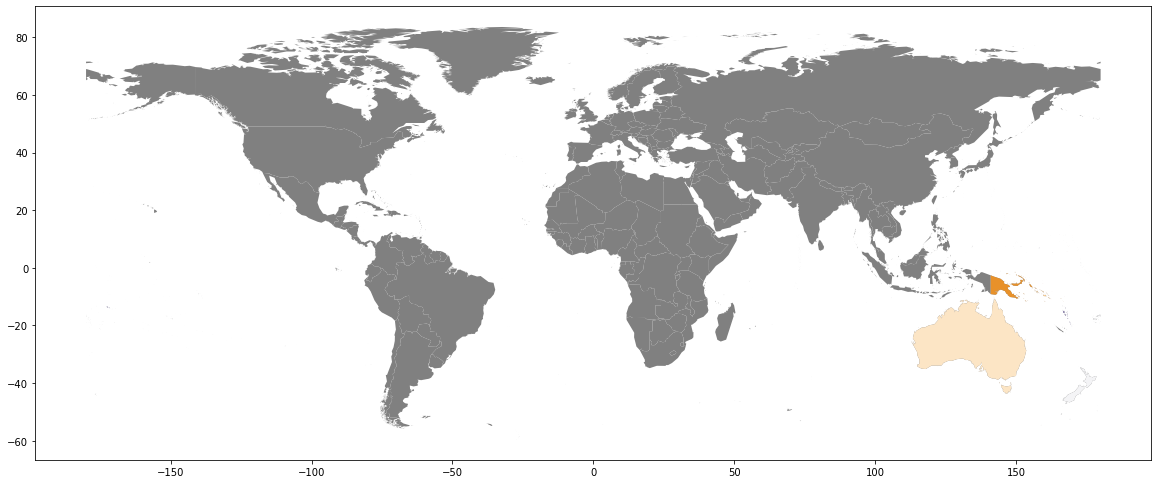

In [139]:
fig, ax = plt.subplots(figsize=(20,20))

countries_wgs84.plot(color='grey', ax=ax)

pd.concat([countries_wgs84.set_index('ISO3'),
           oceania_error], axis=1).plot(column='covid',
                                               cmap='PuOr_r',
                                               vmax=3,
                                               vmin=-3,
                                               ax=ax)


One possible explaination to the model would be that countries with lower GDP per capita perform fewer tests, therefore reducing the number of cases by milion inhabitants. Yet, many countries with lower GDP per capita count more cases per milion inhabitants than the model predict. This is the case in South America and South East Asia. In addition, many countries with higher GDP per capita outperformed the model: Canada, Norway, Finland, Germany an China. These countries have been recognized for a “good handling” of the pandeic. In the case of Germany, the country has performed more tests than most other European nations.